In [1]:
%pip install openpyxl

  Investissement Mensuel Rendement Annualisé Rendement Cumulé Valeur Finale  \
0                   100€               8.14%           78.59%    15,715.53€   
1                   250€               8.14%           78.59%    39,288.82€   
2                   500€               8.14%           78.59%    78,577.65€   
3                   750€               8.14%           78.59%   117,866.47€   

  Valeur Finale Après Impôt Durée de l'Investissement  
0                13,640.87€                  7.14 ans  
1                34,102.18€                  7.14 ans  
2                68,204.35€                  7.14 ans  
3               102,306.53€                  7.14 ans  


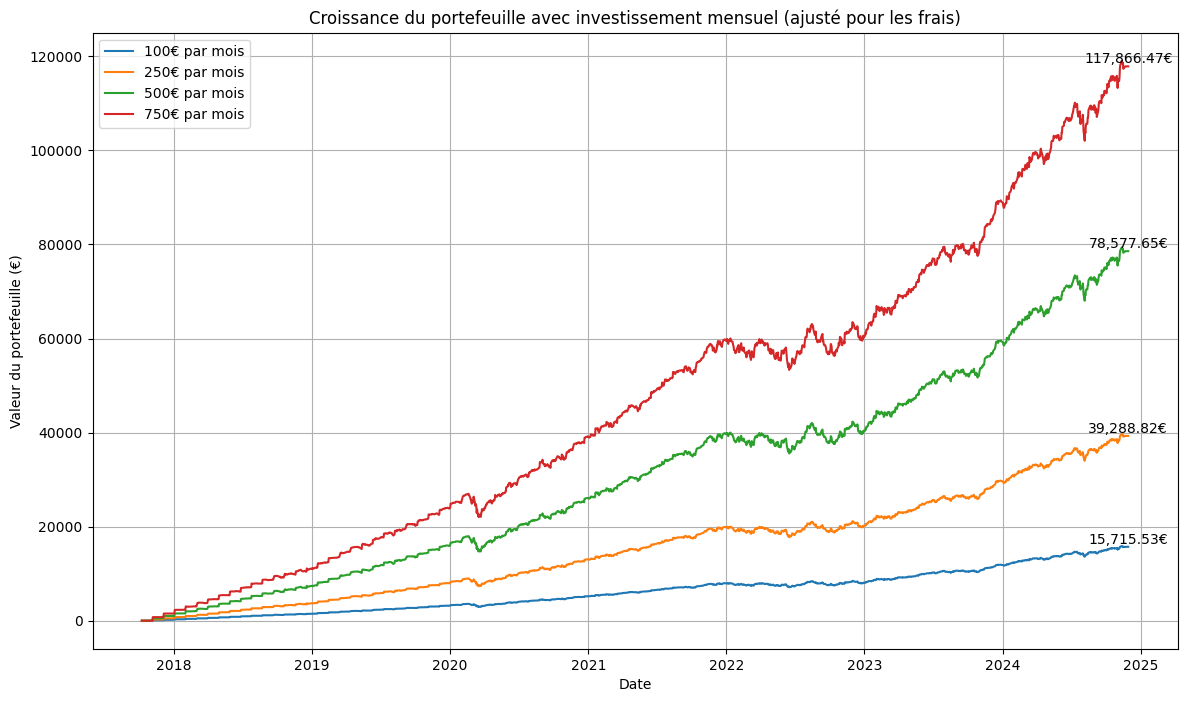

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les fichiers Excel
files = {
    "Euro Gov Bond": "Historique VL Euro Gov Bond.xlsx",
    "Euro STOXX 50": "HistoricalData EuroStoxx 50.xlsx",
    "NASDAQ": "AMUNDI NASDAQ.xlsx",
    "Core S&P 500": "IShares Core SP500.xlsx",
    "PIMCO Euro Short": "PIMCO Euro Short-Term High Yield Corporate Bond Index UCITS ETF.xlsx",
}

df_gov_bond = pd.read_excel(files["Euro Gov Bond"])
df_stoxx50 = pd.read_excel(files["Euro STOXX 50"])
df_nasdaq = pd.read_excel(files["NASDAQ"])
df_sp500 = pd.read_excel(files["Core S&P 500"])
df_pimco = pd.read_excel(files["PIMCO Euro Short"])

# Prétraitement des fichiers
def preprocess_data(df, column_name):
    """
    Prépare les données en format datetime, trie par date (croissant), et renomme la colonne NAV.
    """
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
    df = df.dropna(subset=['Date']).sort_values(by='Date', ascending=True).reset_index(drop=True)
    df.rename(columns={'NAV': column_name}, inplace=True)
    return df

# Préparer chaque fichier
df_gov_bond = preprocess_data(df_gov_bond, 'VL_Gov_Bond')
df_stoxx50 = preprocess_data(df_stoxx50, 'VL_Stoxx50')
df_nasdaq = preprocess_data(df_nasdaq, 'VL_NASDAQ')
df_sp500 = preprocess_data(df_sp500, 'VL_SP500')
df_pimco = preprocess_data(df_pimco, 'VL_PIMCO')

# Limiter les données à partir de la date minimale
start_date = pd.to_datetime("2017-10-09")
for df in [df_gov_bond, df_stoxx50, df_nasdaq, df_sp500, df_pimco]:
    df = df[df['Date'] >= start_date]

# Fusionner les données sur la base des dates
dfs = [df_gov_bond, df_stoxx50, df_nasdaq, df_sp500, df_pimco]
df_combined = dfs[0]
for df in dfs[1:]:
    df_combined = pd.merge(df_combined, df[['Date', df.columns[-1]]], on='Date', how='outer')

# Trier les dates et interpoler/remplir les valeurs manquantes
df_combined = df_combined.sort_values(by='Date', ascending=True).reset_index(drop=True)
df_combined.iloc[:, 1:] = (
    df_combined.iloc[:, 1:]
    .interpolate(method='linear', axis=0)
    .ffill()  # Remplit les NaN par les valeurs précédentes
    .bfill()  # Remplit les NaN restants par les valeurs suivantes
)

# Frais courants (exprimés en pourcentage annuel)
frais = {
    'VL_Gov_Bond': 0.15,         # 0.15% pour Euro Gov Bond
    'VL_Stoxx50': 0.09,          # 0.09% pour Euro STOXX 50
    'VL_PIMCO': 0.50,            # 0.50% pour PIMCO Euro Short-Term
    'VL_SP500': 0.07,            # 0.07% pour Core S&P 500
    'VL_NASDAQ': 0.22            # 0.22% pour Nasdaq
}

# Appliquer les frais sur les VL
def apply_fees(df, frais):
    """
    Ajuste les VL pour prendre en compte les frais courants.
    Les frais sont appliqués quotidiennement sur une base annuelle.
    """
    days_in_year = 365.25
    for col, fee in frais.items():
        if col in df.columns:
            daily_fee = (1 - fee / 100) ** (1 / days_in_year)
            df[col] = df[col] * (daily_fee ** np.arange(len(df)))
    return df

df_combined = apply_fees(df_combined, frais)

# Définir les pondérations du portefeuille
weights = {
    'VL_Gov_Bond': 0.38,
    'VL_PIMCO': 0.12,  # Correspond à PIMCO Euro Short-Term
    'VL_Stoxx50': 0.20,
    'VL_SP500': 0.15,
    'VL_NASDAQ': 0.15,
}

# Calculer la valeur du portefeuille
def calculate_portfolio_value(df, weights):
    """
    Calcule la valeur totale du portefeuille en pondérant les VL par leurs poids.
    """
    portfolio_value = sum(
        weights[col] * df[col] / df[col].iloc[0] for col in weights
    ) * 10000  # Base initiale de 10 000€
    return portfolio_value

df_combined['Portfolio_Value'] = calculate_portfolio_value(df_combined, weights)

# Simulation d'investissement mensuel
def simulate_monthly_investment(df, monthly_investments):
    """
    Simule des investissements mensuels et retourne les résultats pour chaque montant.
    """
    results = {}
    for investment in monthly_investments:
        portfolio_value = []
        total_capital = 0
        capital_cumulative = []
        interests_cumulative = []
        
        for i, row in df.iterrows():
            if i % 21 == 0 and i != 0:  # Approximation : 21 jours ouvrés par mois
                total_capital += investment
            capital_cumulative.append(total_capital)
            portfolio_value.append(row['Portfolio_Value'] * (total_capital / 10000))
            interests_cumulative.append(portfolio_value[-1] - capital_cumulative[-1])
        
        results[investment] = {
            'Portfolio': portfolio_value,
            'Capital': capital_cumulative,
            'Interests': interests_cumulative
        }
    
    return results

# Configurer les montants mensuels
monthly_investments = [100, 250, 500, 750]
simulation_results = simulate_monthly_investment(df_combined, monthly_investments)

# Calcul de la performance
def calculate_performance(df, results):
    """
    Calcule la performance du portefeuille pour chaque scénario d'investissement.
    """
    performance_table = []
    for investment, data in results.items():
        total_return = (data['Portfolio'][-1] / data['Capital'][-1]) - 1  # Rendement cumulé
        annualized_return = (1 + total_return) ** (1 / (len(df) / 252)) - 1  # Rendement annualisé
        final_value = data['Portfolio'][-1]
        final_capital = data['Capital'][-1]
        gross_gain = final_value - final_capital
        net_gain = gross_gain * 0.70  # Appliquer la fiscalité (PFU 30%)
        final_value_after_tax = final_capital + net_gain
        num_years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
        
        performance_table.append([
            f"{investment}€",
            f"{annualized_return*100:.2f}%",
            f"{total_return*100:.2f}%",
            f"{final_value:,.2f}€",
            f"{final_value_after_tax:,.2f}€",
            f"{num_years:.2f} ans"
        ])
    
    return pd.DataFrame(performance_table, columns=[
        "Investissement Mensuel",
        "Rendement Annualisé",
        "Rendement Cumulé",
        "Valeur Finale",
        "Valeur Finale Après Impôt",
        "Durée de l'Investissement"
    ])

performance_df = calculate_performance(df_combined, simulation_results)

# Affichage du tableau de performance
print(performance_df)

# Visualisation de la croissance du portefeuille
plt.figure(figsize=(14, 8))
for investment, data in simulation_results.items():
    plt.plot(df_combined['Date'], data['Portfolio'], label=f'{investment}€ par mois')
    plt.text(df_combined['Date'].iloc[-1], data['Portfolio'][-1], f'{data["Portfolio"][-1]:,.2f}€',
             color='black', ha='center', va='bottom', fontsize=10)

plt.title("Croissance du portefeuille avec investissement mensuel (ajusté pour les frais)")
plt.xlabel("Date")
plt.ylabel("Valeur du portefeuille (€)")
plt.legend()
plt.grid(True)
plt.show()

  Investissement Mensuel Rendement Annualisé Rendement Cumulé Valeur Finale  \
0                   100€               5.30%           46.73%    13,058.69€   
1                   250€               5.30%           46.73%    32,646.72€   
2                   500€               5.30%           46.73%    65,293.44€   
3                   750€               5.30%           46.73%    97,940.17€   

  Valeur Finale Après Impôt Durée de l'Investissement  
0                11,811.08€                  7.15 ans  
1                29,527.71€                  7.15 ans  
2                59,055.41€                  7.15 ans  
3                88,583.12€                  7.15 ans  


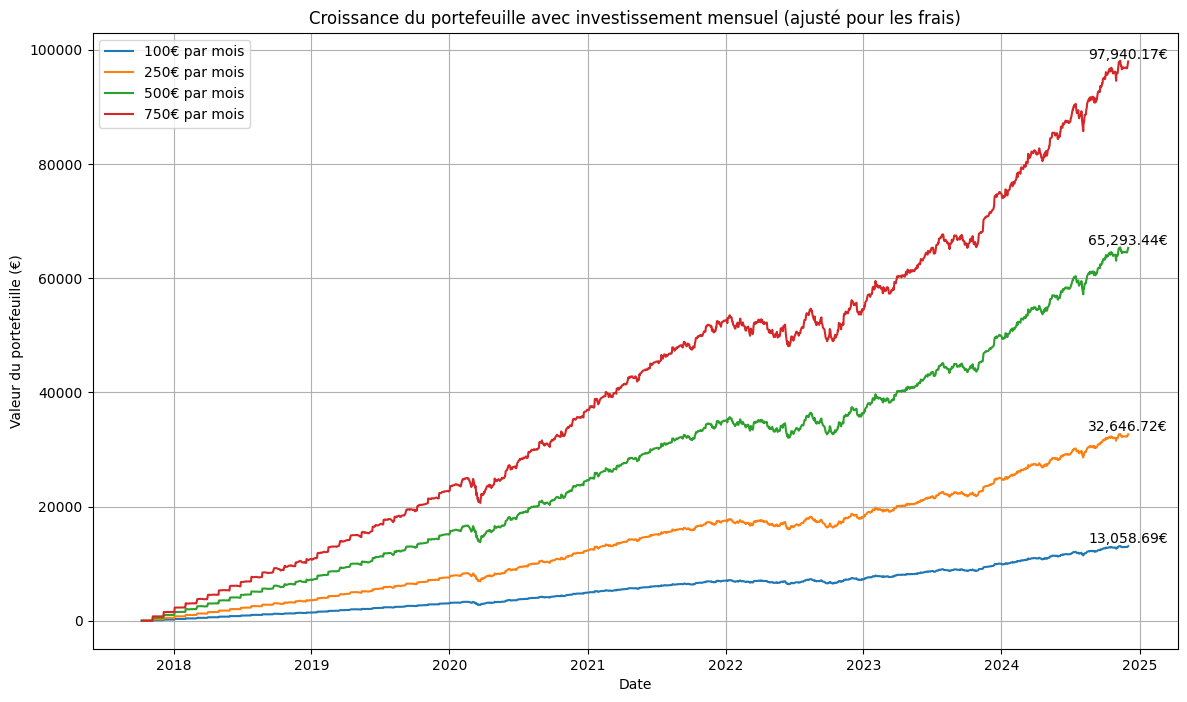

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Charger les fichiers Excel
files = {
    "Euro Gov Bond": "Historique VL Euro Gov Bond.xlsx",
    "Euro STOXX 50": "HistoricalData EuroStoxx 50.xlsx",
    "NASDAQ": "AMUNDI NASDAQ.xlsx",
    "Core S&P 500": "IShares Core SP500.xlsx",
    "PIMCO Euro Short": "PIMCO Euro Short-Term High Yield Corporate Bond Index UCITS ETF.xlsx",
    "Asia EM": "Amundi MSCI Em Asia LU1681044563.xlsx",  # Fonds asiatique
}

df_gov_bond = pd.read_excel(files["Euro Gov Bond"])
df_stoxx50 = pd.read_excel(files["Euro STOXX 50"])
df_nasdaq = pd.read_excel(files["NASDAQ"])
df_sp500 = pd.read_excel(files["Core S&P 500"])
df_pimco = pd.read_excel(files["PIMCO Euro Short"])
df_asia = pd.read_excel(files["Asia EM"])  # Charger le fonds asiatique

# Prétraitement des fichiers
def preprocess_data(df, column_name):
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', dayfirst=True)
    df = df.dropna(subset=['Date']).sort_values(by='Date', ascending=True).reset_index(drop=True)
    df.rename(columns={'NAV': column_name}, inplace=True)
    return df

# Préparer chaque fichier
df_gov_bond = preprocess_data(df_gov_bond, 'VL_Gov_Bond')
df_stoxx50 = preprocess_data(df_stoxx50, 'VL_Stoxx50')
df_nasdaq = preprocess_data(df_nasdaq, 'VL_NASDAQ')
df_sp500 = preprocess_data(df_sp500, 'VL_SP500')
df_pimco = preprocess_data(df_pimco, 'VL_PIMCO')
df_asia = preprocess_data(df_asia, 'VL_Asia')

# Limiter les données à partir de la date minimale
start_date = pd.to_datetime("2017-10-09")
for df in [df_gov_bond, df_stoxx50, df_nasdaq, df_sp500, df_pimco, df_asia]:
    df = df[df['Date'] >= start_date]

# Fusionner les données sur la base des dates
dfs = [df_gov_bond, df_stoxx50, df_nasdaq, df_sp500, df_pimco, df_asia]
df_combined = dfs[0]
for df in dfs[1:]:
    df_combined = pd.merge(df_combined, df[['Date', df.columns[-1]]], on='Date', how='outer')

# Trier les dates et interpoler/remplir les valeurs manquantes
df_combined = df_combined.sort_values(by='Date', ascending=True).reset_index(drop=True)
df_combined.iloc[:, 1:] = (
    df_combined.iloc[:, 1:]
    .interpolate(method='linear', axis=0)
    .ffill()
    .bfill()
)

# Frais courants (exprimés en pourcentage annuel)
frais = {
    'VL_Gov_Bond': 0.15,
    'VL_Stoxx50': 0.09,
    'VL_PIMCO': 0.50,
    'VL_SP500': 0.07,
    'VL_NASDAQ': 0.22,
    'VL_Asia': 0.20
}

def apply_fees(df, frais):
    days_in_year = 365.25
    for col, fee in frais.items():
        if col in df.columns:
            daily_fee = (1 - fee / 100) ** (1 / days_in_year)
            df[col] = df[col] * (daily_fee ** np.arange(len(df)))
    return df

df_combined = apply_fees(df_combined, frais)

# Définir les pondérations ajustées
weights = {
    'VL_Gov_Bond': 0.38,
    'VL_PIMCO': 0.12,
    'VL_Stoxx50': 0.10,  # Ajusté à 10 %
    'VL_SP500': 0.25,
    'VL_NASDAQ': 0,
    'VL_Asia': 0.15,  # Nouveau fonds asiatique
}

def calculate_portfolio_value(df, weights):
    portfolio_value = sum(
        weights[col] * df[col] / df[col].iloc[0] for col in weights
    ) * 10000
    return portfolio_value

df_combined['Portfolio_Value'] = calculate_portfolio_value(df_combined, weights)

# Simulation d'investissement mensuel
def simulate_monthly_investment(df, monthly_investments):
    results = {}
    for investment in monthly_investments:
        portfolio_value = []
        total_capital = 0
        capital_cumulative = []
        interests_cumulative = []
        
        for i, row in df.iterrows():
            if i % 21 == 0 and i != 0:
                total_capital += investment
            capital_cumulative.append(total_capital)
            portfolio_value.append(row['Portfolio_Value'] * (total_capital / 10000))
            interests_cumulative.append(portfolio_value[-1] - capital_cumulative[-1])
        
        results[investment] = {
            'Portfolio': portfolio_value,
            'Capital': capital_cumulative,
            'Interests': interests_cumulative
        }
    
    return results

# Configurer les montants mensuels
monthly_investments = [100, 250, 500, 750]
simulation_results = simulate_monthly_investment(df_combined, monthly_investments)

# Calcul de la performance
def calculate_performance(df, results):
    performance_table = []
    for investment, data in results.items():
        total_return = (data['Portfolio'][-1] / data['Capital'][-1]) - 1
        annualized_return = (1 + total_return) ** (1 / (len(df) / 252)) - 1
        final_value = data['Portfolio'][-1]
        final_capital = data['Capital'][-1]
        gross_gain = final_value - final_capital
        net_gain = gross_gain * 0.70
        final_value_after_tax = final_capital + net_gain
        num_years = (df['Date'].iloc[-1] - df['Date'].iloc[0]).days / 365.25
        
        performance_table.append([
            f"{investment}€",
            f"{annualized_return*100:.2f}%",
            f"{total_return*100:.2f}%",
            f"{final_value:,.2f}€",
            f"{final_value_after_tax:,.2f}€",
            f"{num_years:.2f} ans"
        ])
    
    return pd.DataFrame(performance_table, columns=[
        "Investissement Mensuel",
        "Rendement Annualisé",
        "Rendement Cumulé",
        "Valeur Finale",
        "Valeur Finale Après Impôt",
        "Durée de l'Investissement"
    ])

performance_df = calculate_performance(df_combined, simulation_results)

# Affichage du tableau de performance
print(performance_df)

# Visualisation de la croissance du portefeuille
plt.figure(figsize=(14, 8))
for investment, data in simulation_results.items():
    plt.plot(df_combined['Date'], data['Portfolio'], label=f'{investment}€ par mois')
    plt.text(df_combined['Date'].iloc[-1], data['Portfolio'][-1], f'{data["Portfolio"][-1]:,.2f}€',
             color='black', ha='center', va='bottom', fontsize=10)

plt.title("Croissance du portefeuille avec investissement mensuel (ajusté pour les frais)")
plt.xlabel("Date")
plt.ylabel("Valeur du portefeuille (€)")
plt.legend()
plt.grid(True)
plt.show()